# Ruoff evaluation

- a-c) legend for fits
- d) Quantitative comparison between approaches
- e) Pie chart success rate
- f) Convergence in successful fits

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sys 
from pathlib import Path
sys.path.append(str(Path(".").resolve().parent))

from helpers_ruoff import (
    load_measurements, 
    load_reference, 
    plot_fit, 
    load_exp_summary, 
    TEST_ENDPOINT,
    TRAINING_ENDPOINT,
    OBSERVABLES_IDS,
    OBSERVED,
)

dir_pipeline = Path(".").resolve().parents[1]
output_path = Path(".") / "Fig3"

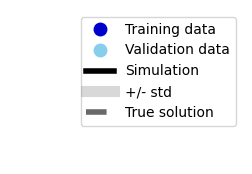

In [2]:
# Plot the legend separately
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor="mediumblue", markeredgecolor="none", markersize=10),
    Line2D([0], [0], marker='o', color='none', markerfacecolor='skyblue', markeredgecolor="none", markersize=10),
    Line2D([0], [0], color='k', lw=4),
    Line2D([0], [0], color='grey', alpha=0.3, lw=8),
    Line2D([0], [0], color="dimgrey", lw=4, linestyle="dashed"),
]
labels = [
    'Training data',
    'Validation data',
    'Simulation',
    '+/- std',
    'True solution',
]

fig, ax = plt.subplots(figsize=(3, 2))
ax.legend(custom_lines, labels)
ax.axis('off')
fig.savefig(output_path / "legend.svg", transparent=True)

### d) Bar diagrams comparing run time, train, and test metric

- The computation time is misleading. MS takes much longer than just that one start

In [3]:
df = pd.DataFrame(
    columns=["Approach", "Optimiser Runtime", "Train NMAE", "Test NMAE"],
    data=[
        ["Standard", 39.7841, 0.07897, 0.3383],
        ["Adapted", 1.3355, 0.1119, 100],
        ["Multi-start",  2.1164,  0.037193,  0.213156]
    ],
)
df

,Approach,Optimiser Runtime,Train NMAE,Test NMAE
0,Standard,39.7841,0.078970,0.338300
1,Adapted,1.3355,0.111900,100.000000
2,Multi-start,2.1164,0.037193,0.213156


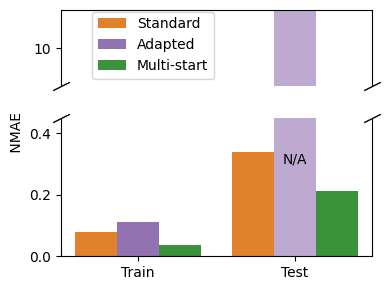

In [4]:
dflong = pd.melt(
    df, 
    id_vars="Approach", 
    value_vars=["Optimiser Runtime", "Train NMAE", "Test NMAE"],
)

fig, (axtop, axbot) = plt.subplots(
    nrows=2, figsize=(4, 3), gridspec_kw={"height_ratios": [11, 20]},
)
palette = {
    "Standard": "tab:orange", "Adapted": "tab:purple", "Multi-start": "tab:green",
}
for ax in (axtop, axbot):
    sns.barplot(
        dflong[dflong['variable'].str.contains("NMAE")], 
        x="variable", 
        y="value", 
        hue="Approach",
        palette=palette,
        ax=ax,
    )
    ax.set_xlabel(None)
axbot.set_ylabel(" " * 25 + "NMAE")
axbot.set_xticks([0, 1], ["Train", "Test"])

# zoom-in / limit the view to different portions of the data
axtop.set_ylim(9, 11)
axbot.set_ylim(0, 0.45)

# hide the spines between the axes
axbot.spines.top.set_visible(False)
axbot.xaxis.tick_bottom()
axtop.spines.bottom.set_visible(False)
axtop.set_xticks([])

# slanted lines between the axes
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axtop.plot([0, 1], [0, 0], transform=axtop.transAxes, **kwargs)
axbot.plot([0, 1], [1, 1], transform=axbot.transAxes, **kwargs)

# y label top
axtop.set_yticks(axtop.get_yticks()[1:2])
axtop.set_ylabel(None)

# make NaN bar different
# plt.rcParams.update({'hatch.color': 'white'})
# axtop.patches[3].set_hatch("///")
# axbot.patches[3].set_hatch("///")
axtop.patches[3].set_alpha(0.6)
axbot.patches[3].set_alpha(0.6)

axbot.text(s="N/A", x=0.92, y=0.3)

# legend
axtop.legend(loc=(0.1, 0.1))
axbot.get_legend().remove()

fig.tight_layout()
fig.savefig(output_path / "barplots_nmae.svg", transparent=True)

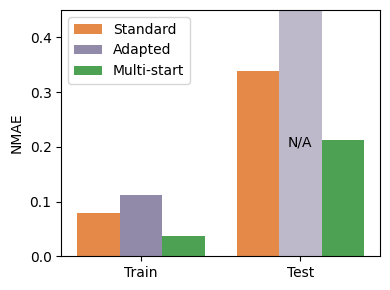

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))
palette = {
    "Standard": (255/255, 132/255, 47/255, 1), 
    "Adapted": (142/255, 134/255, 174/255, 1),
    "Multi-start": (63/255, 175/255, 70/255, 1),
}

sns.barplot(
    dflong[dflong['variable'].str.contains("NMAE")], 
    x="variable", 
    y="value", 
    hue="Approach",
    palette=palette,
    ax=ax,
)
ax.set_xlabel(None)
ax.set_ylabel("NMAE")
ax.set_xticks([0, 1], ["Train", "Test"])
# zoom-in / limit the view to different portions of the data
ax.set_ylim(0, 0.45)

# make NaN bar different
ax.patches[3].set_alpha(0.6)
ax.text(s="N/A", x=0.92, y=0.2)

# legend
ax.legend()

fig.tight_layout()
fig.savefig(output_path / "barplots_nmae.svg", transparent=True)

### e) Fraction of successful fits in multi-start pipeline

In [6]:
experiment_name = "2024_07_22_Ruoff_Grid"
dir_exp_output = dir_pipeline / "5_optimisation" / experiment_name
summary = load_exp_summary(dir_exp_output).query("noise_level == 5 & (sparsity == 150)")
print(summary.shape)

(9984, 47)


In [7]:
metric = "nmae_obs_test"
threshold = 0.15

def map_success(x, threshold=threshold):
    if x < threshold:
        return "Success"
    else:
        return "Failed"

summary["success"] = summary[metric].apply(lambda x: map_success(x))
success_dict = summary["success"].value_counts().to_dict()

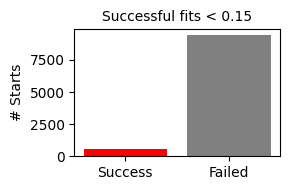

In [8]:
fig, ax = plt.subplots(figsize=(3, 2))
ax.bar(
    ["Success", "Failed"],
    [
        success_dict["Success"],
        success_dict["Failed"],
    ],
    color = ["red", "grey"]
)
ax.set_ylabel("# Starts")
# ax.set_yscale("log")
ax.set_title(f"Successful fits < {threshold}", fontsize="medium")

fig.tight_layout()
fig.savefig(output_path / "barplots_success.svg", transparent=True)

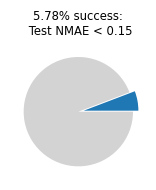

In [9]:
fig, ax = plt.subplots(figsize=(3, 2))
wedges, texts = ax.pie(
    [
        success_dict["Success"],
        success_dict["Failed"],
    ],
    explode = (0.1, 0),
    # labels = ["Success", "Failed"],
    colors = ["tab:blue", "lightgrey"],
    # autopct='%1.f%%',
    # pctdistance=1.25,
)
success_percent = round(success_dict["Success"] / (success_dict['Failed'] + success_dict['Success']) * 100, 2)
ax.set_title(f"{success_percent}% success:\n Test NMAE < {threshold}", fontsize='small')


fig.tight_layout()
fig.savefig(output_path / f"pie_success_{str(threshold).replace('.', '_')}.svg", transparent=True)

### f) Waterfall, convergence

In [10]:
import pypesto
from pypesto.visualize import waterfall

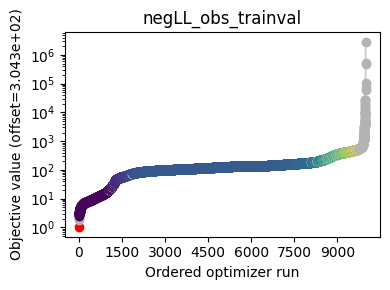

In [11]:
# waterfall plot multi-start pipeline, training loss
metric_train = "negLL_obs_trainval"

optimize_result = pypesto.result.OptimizeResult()
for key, val in summary[metric_train].to_dict().items():
    single_result = pypesto.result.OptimizerResult(**{"id": str(key), "fval": val})
    optimize_result.append(single_result)
pypesto_result = pypesto.Result(optimize_result=optimize_result)
fig, ax = plt.subplots(figsize=(4, 3))
waterfall(
    results=pypesto_result,
    # n_starts_to_zoom=100,
    ax=ax,
)
ax.set_title(metric_train)
# fig.suptitle("Waterfall: " + dataset_id.replace("_", " "))
fig.tight_layout()
fig.savefig(output_path / f"waterfall_{metric_train}.svg", transparent=True)

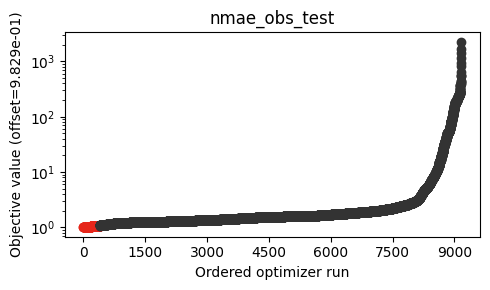

In [12]:
# waterfall plot multi-start pipeline, test loss
metric_test = "nmae_obs_test"

optimize_result = pypesto.result.OptimizeResult()
for key, val in list(summary[metric_test].sort_values(ascending=True).to_dict().items()): #[::10]:
    single_result = pypesto.result.OptimizerResult(**{"id": str(key), "fval": val})
    optimize_result.append(single_result)
pypesto_result = pypesto.Result(optimize_result=optimize_result)

# assign colors because test loss does not work well with pypesto's colour gradient
def assign_color(input):
    if np.isnan(input):
        return (0, 1, 1, 1)
    if input <= 0.1:
        # red
        return (0.9, 0.15, 0.1, 0.5)
    else:
        # grey
        return (0.2, 0.2, 0.2, 1)

colors = [assign_color(c) for c in pypesto_result.optimize_result.fval]

fig, ax = plt.subplots(figsize=(5, 3))
waterfall(
    results=pypesto_result,
    ax=ax,
    colors=colors,
)
ax.set_title(metric_test)
# fig.suptitle("Waterfall: " + dataset_id.replace("_", " "))
fig.tight_layout()
fig.savefig(output_path / f"waterfall_{metric_test}.svg", transparent=True)

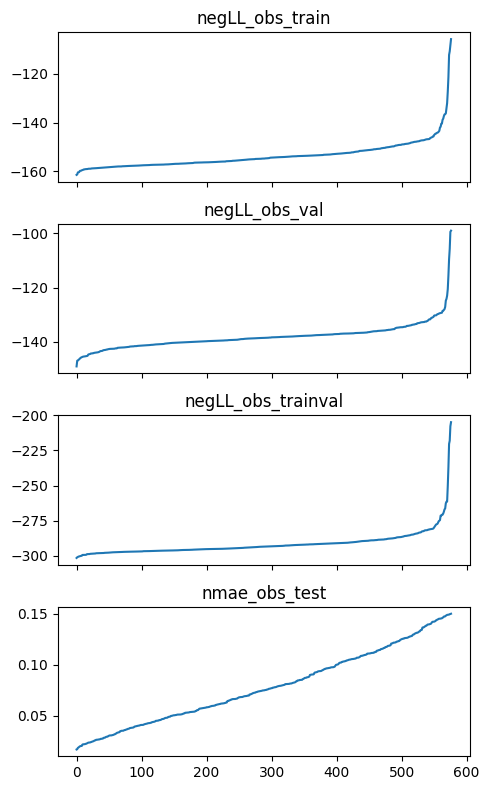

In [13]:
success_losses = summary.query(
    'success == "Success"'
).sort_values(by=[metric_train]).reset_index(drop=True)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5, 8))
for axis, metric in zip(ax, ["negLL_obs_train", "negLL_obs_val", metric_train, metric_test]):
    axis.plot(sorted(success_losses[metric]))
    axis.set_title(metric)
fig.tight_layout()

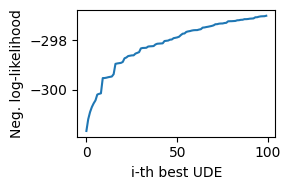

In [14]:
fig, ax = plt.subplots(figsize=(3, 2))
n_ = 100
ax.plot(success_losses["negLL_obs_trainval"][:n_])
ax.set_ylabel("Neg. log-likelihood")
ax.set_xlabel("i-th best UDE")
fig.tight_layout()
fig.savefig(output_path / f"{n_}_best_nlls.svg", transparent=True)